<a href="https://colab.research.google.com/github/pauloacs/DeepCFD/blob/main/Navier_inf_tf2.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing **latex** & pyDOE

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
!apt install cm-super
pip install --upgrade pyDOE

# FIGURES

In [ ]:
import numpy as np
import matplotlib as mpl
from datetime import datetime
import sys
import os
import json

def saveResultDir(save_path, save_hp):
    now = datetime.now()
    scriptName =  os.path.splitext(os.path.basename(sys.argv[0]))[0]
    resDir = os.path.join(save_path, "results", f"{now.strftime('%Y%m%d-%H%M%S')}-{scriptName}")
    os.mkdir(resDir)
    print("Saving results to directory ", resDir)
    savefig(os.path.join(resDir, "graph"))
    with open(os.path.join(resDir, "hp.json"), "w") as f:
        json.dump(save_hp, f)


# MIT License
# 
# Copyright (c) 2018 maziarraissi
# 
# https://github.com/maziarraissi/PINNs

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        # plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        # plt.savefig('{}.eps'.format(filename))
        plt.savefig('{}.png'.format(filename))

## Simple plot
#fig, ax  = newfig(1.0)
#
#def ema(y, a):
#    s = []
#    s.append(y[0])
#    for t in range(1, len(y)):
#        s.append(a * y[t] + (1-a) * s[t-1])
#    return np.array(s)
#    
#y = [0]*200
#y.extend([20]*(1000-len(y)))
#s = ema(y, 0.01)
#
#ax.plot(s)
#ax.set_xlabel('X Label')
#ax.set_ylabel('EMA')
#
#savefig('ema')

# INFORMATIONS

In [ ]:
import json
import tensorflow as tf
import time
from datetime import datetime


class Logger(object):
    def __init__(self, hp):
        print("Hyperparameters:")
        print(json.dumps(hp, indent=2))
        print()

        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.prev_time = self.start_time
        self.frequency = hp["log_frequency"]

    def get_epoch_duration(self):
        now = time.time()
        edur = datetime.fromtimestamp(now - self.prev_time) \
            .strftime("%S.%f")[:-5]
        self.prev_time = now
        return edur

    def get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time) \
                .strftime("%M:%S")

    def get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn

    def log_train_start(self, model, model_description=False):
        print("\nTraining started")
        print("================")
        self.model = model
        if model_description:
            print(model.summary())

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            name = 'nt_epoch' if is_iter else 'tf_epoch'
            print(f"{name} = {epoch:6d}  " +
                  f"elapsed = {self.get_elapsed()} " +
                  f"(+{self.get_epoch_duration()})  " +
                  f"loss = {loss:.4e}  " + custom)

    def log_train_opt(self, name):
        print(f"-- Starting {name} optimization --")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): " +
              f"duration = {self.get_elapsed()}  " +
              f"error = {self.get_error_u():.4e}  " + custom)

Defining the costum NN

In [ ]:
import tensorflow as tf
import numpy as np

class NeuralNetwork(object):
    def __init__(self, hp, logger, ub, lb):

        layers = hp["layers"]

        # Setting up the optimizers with the hyper-parameters
        self.nt_config = Struct()
        self.nt_config.learningRate = hp["nt_lr"]
        self.nt_config.maxIter = hp["nt_epochs"]
        self.nt_config.nCorrection = hp["nt_ncorr"]
        self.nt_config.tolFun = 1.0 * np.finfo(float).eps
        self.tf_epochs = hp["tf_epochs"]
        self.tf_optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp["tf_lr"],
            beta_1=hp["tf_b1"],
            epsilon=hp["tf_eps"])

        self.dtype = "float64"
        # Descriptive Keras model
        tf.keras.backend.set_floatx(self.dtype)
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.model.add(tf.keras.layers.Lambda(
            lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:-1]:
            self.model.add(tf.keras.layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal"))
        self.model.add(tf.keras.layers.Dense(
                layers[-1], activation=None,
                kernel_initializer="glorot_normal"))

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.logger = logger

    # Defining custom loss
    # @tf.function
    def loss(self, u, u_pred):
        return tf.reduce_mean(tf.square(u - u_pred))

    # @tf.function
    def grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.loss(u, self.model(X))
        grads = tape.gradient(loss_value, self.wrap_training_variables())
        return loss_value, grads

    def wrap_training_variables(self):
        var = self.model.trainable_variables
        return var

    def get_params(self, numpy=False):
        return []

    def get_weights(self, convert_to_tensor=True):
        w = []
        for layer in self.model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        if convert_to_tensor:
            w = self.tensor(w)
        return w

    def set_weights(self, w):
        for i, layer in enumerate(self.model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def get_loss_and_flat_grad(self, X, u):
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.loss(u, self.model(X))
            grad = tape.gradient(loss_value, self.wrap_training_variables())
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value, grad_flat

        return loss_and_flat_grad

    def tf_optimization(self, X_u, u):
        self.logger.log_train_opt("Adam")
        for epoch in range(self.tf_epochs):
            loss_value = self.tf_optimization_step(X_u, u)
            self.logger.log_train_epoch(epoch, loss_value)

    # @tf.function
    def tf_optimization_step(self, X_u, u):
        loss_value, grads = self.grad(X_u, u)
        self.tf_optimizer.apply_gradients(
                zip(grads, self.wrap_training_variables()))
        return loss_value

    def nt_optimization(self, X_u, u):
        self.logger.log_train_opt("LBFGS")
        loss_and_flat_grad = self.get_loss_and_flat_grad(X_u, u)
        # tfp.optimizer.lbfgs_minimize(
        #   loss_and_flat_grad,
        #   initial_position=self.get_weights(),
        #   num_correction_pairs=nt_config.nCorrection,
        #   max_iterations=nt_config.maxIter,
        #   f_relative_tolerance=nt_config.tolFun,
        #   tolerance=nt_config.tolFun,
        #   parallel_iterations=6)
        self.nt_optimization_steps(loss_and_flat_grad)

    def nt_optimization_steps(self, loss_and_flat_grad):
        lbfgs(loss_and_flat_grad,
              self.get_weights(),
              self.nt_config, Struct(), True,
              lambda epoch, loss, is_iter:
              self.logger.log_train_epoch(epoch, loss, "", is_iter))

    def fit(self, X_u, u):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = self.tensor(X_u)
        u = self.tensor(u)

        # Optimizing
        self.tf_optimization(X_u, u)
        self.nt_optimization(X_u, u)

        self.logger.log_train_end(self.tf_epochs + self.nt_config.maxIter)

    def predict(self, X_star):
        u_pred = self.model(X_star)
        return u_pred.numpy()

    def summary(self):
        return self.model.summary()

    def tensor(self, X):
        return tf.convert_to_tensor(X, dtype=self.dtype)

## Defining **lbfgs**

In [ ]:
#%% Adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  if config.maxIter == 0:
    return

  global final_loss, times
  
  maxIter = config.maxIter
  maxEval = config.maxEval or maxIter*1.25
  tolFun = config.tolFun or 1e-5
  tolX = config.tolX or 1e-19
  nCorrection = config.nCorrection or 100
  lineSearch = config.lineSearch
  lineSearchOpts = config.lineSearchOptions
  learningRate = config.learningRate or 1
  isverbose = config.verbose or False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

    # evaluate initial f(x) and df/dx
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate


    # optional line search: user function
    lsFuncEval = 0
    if lineSearch and isinstance(lineSearch) == types.FunctionType:
      # perform line search, using user function
      f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
      f_hist.append(f)
    else:
      # no line search, simply move with fixed-step
      x += t*d
      
      if nIter != maxIter:
        # re-evaluate function only if not in last iteration
        # the reason we do this: in a stochastic setting,
        # no use to re-evaluate that function here
        f, g = opfunc(x)
        lsFuncEval = 1
        f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      verbose('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      verbose('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      verbose('step size below tolX')
      break

    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      log_fn(nIter, f.numpy(), True)
      #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
      record_time()
      times.append(last_time())

    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

# Utilities:


1.   Prepare data function
2.   Plotting function



In [ ]:
#%% Utils for Burger's equation

import scipy.io
import numpy as np
import tensorflow as tf
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# "." for Colab/VSCode, and ".." for GitHub
repoPath = os.path.join(".", "PINNs")
# repoPath = os.path.join("..", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")

def prep_data(path, N_u=None, N_f=None, N_n=None, q=None, ub=None, lb=None, noise=0.0, idx_t_0=None, idx_t_1=None, N_0=None, N_1=None):
    # Reading external data [t is 100x1, usol is 256x100 (solution), x is 256x1]
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['t'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['usol']).T # T x N

    # x = np.load("1d-burgers/data/burgers_x.npy")[:, None]
    # t = np.load("1d-burgers/data/burgers_t.npy")[:, None]
    # Exact_u = np.load("1d-burgers/data/burgers_u.npy").T

    if N_n != None and q != None and ub != None and lb != None and idx_t_0 != None and idx_t_1 != None:
      dt = t[idx_t_1] - t[idx_t_0]
      idx_x = np.random.choice(Exact_u.shape[1], N_n, replace=False) 
      x_0 = x[idx_x,:]
      u_0 = Exact_u[idx_t_0:idx_t_0+1,idx_x].T
      u_0 = u_0 + noise*np.std(u_0)*np.random.randn(u_0.shape[0], u_0.shape[1])
        
      # Boudanry data
      x_1 = np.vstack((lb, ub))
      
      # Test data
      x_star = x
      u_star = Exact_u[idx_t_1,:]

      # Load IRK weights
      tmp = np.float32(np.loadtxt(os.path.join(utilsPath, "IRK_weights", "Butcher_IRK%d.txt" % (q)), ndmin = 2))
      IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
      IRK_times = tmp[q**2+q:]

      return x, t, dt, Exact_u, x_0, u_0, x_1, x_star, u_star, IRK_weights, IRK_times

    # Meshing x and t in 2D (256,100)
    X, T = np.meshgrid(x,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    u_star = Exact_u.flatten()[:,None]
                
    # Noiseless data TODO: add support for noisy data    
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    if N_0 != None and N_1 != None:
      Exact_u = Exact_u.T
      idx_x = np.random.choice(Exact_u.shape[0], N_0, replace=False)
      x_0 = x[idx_x,:]
      u_0 = Exact_u[idx_x,idx_t_0][:,None]
      u_0 = u_0 + noise*np.std(u_0)*np.random.randn(u_0.shape[0], u_0.shape[1])
          
      idx_x = np.random.choice(Exact_u.shape[0], N_1, replace=False)
      x_1 = x[idx_x,:]
      u_1 = Exact_u[idx_x,idx_t_1][:,None]
      u_1 = u_1 + noise*np.std(u_1)*np.random.randn(u_1.shape[0], u_1.shape[1])
      
      dt = np.asscalar(t[idx_t_1] - t[idx_t_0])        
      q = int(np.ceil(0.5*np.log(np.finfo(float).eps)/np.log(dt)))

      # Load IRK weights
      tmp = np.float32(np.loadtxt(os.path.join(utilsPath, "IRK_weights", "Butcher_IRK%d.txt" % (q)), ndmin = 2))
      weights =  np.reshape(tmp[0:q**2+q], (q+1,q))     
      IRK_alpha = weights[0:-1,:]
      IRK_beta = weights[-1:,:] 
      return x_0, u_0, x_1, u_1, x, t, dt, q, Exact_u, IRK_alpha, IRK_beta

    if N_f == None:
      lb = X_star.min(axis=0)
      ub = X_star.max(axis=0) 
      return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb

    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([-1.0, 0.0] and [1.0, 1.0])
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0) 
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact_u[0:1,:].T
    # Getting the lowest boundary conditions (x=-1) 
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact_u[:,0:1]
    # Getting the highest boundary conditions (x=1) 
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact_u[:,-1:]
    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2, xx3])
    u_train = np.vstack([uu1, uu2, uu3])

    # Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 2D domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx,:]
    # Getting the corresponding u_train
    u_train = u_train [idx,:]

    return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

def plot_inf_cont_results(X_star, u_pred, X_u_train, u_train, Exact_u, X, T, x, t, save_path=None, save_hp=None):

  # Interpolating the results on the whole (x,t) domain.
  # griddata(points, values, points at which to interpolate, method)
  U_pred = griddata(X_star, u_pred, (X, T), method='cubic')

  # Creating the figures
  fig, ax = newfig(1.0, 1.1)
  ax.axis('off')

  ####### Row 0: u(t,x) ##################    
  gs0 = gridspec.GridSpec(1, 2)
  gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
  ax = plt.subplot(gs0[:, :])

  h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(h, cax=cax)

  ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

  line = np.linspace(x.min(), x.max(), 2)[:,None]
  ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
  ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
  ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.legend(frameon=False, loc = 'best')
  ax.set_title('$u(t,x)$', fontsize = 10)

  ####### Row 1: u(t,x) slices ##################    
  gs1 = gridspec.GridSpec(1, 3)
  gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

  ax = plt.subplot(gs1[0, 0])
  ax.plot(x,Exact_u[25,:], 'b-', linewidth = 2, label = 'Exact')       
  ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')    
  ax.set_title('$t = 0.25$', fontsize = 10)
  ax.axis('square')
  ax.set_xlim([-1.1,1.1])
  ax.set_ylim([-1.1,1.1])

  ax = plt.subplot(gs1[0, 1])
  ax.plot(x,Exact_u[50,:], 'b-', linewidth = 2, label = 'Exact')       
  ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.axis('square')
  ax.set_xlim([-1.1,1.1])
  ax.set_ylim([-1.1,1.1])
  ax.set_title('$t = 0.50$', fontsize = 10)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

  ax = plt.subplot(gs1[0, 2])
  ax.plot(x,Exact_u[75,:], 'b-', linewidth = 2, label = 'Exact')       
  ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.axis('square')
  ax.set_xlim([-1.1,1.1])
  ax.set_ylim([-1.1,1.1])    
  ax.set_title('$t = 0.75$', fontsize = 10)

  if save_path != None and save_hp != None:
      saveResultDir(save_path, save_hp)

  else:
    plt.show()

def plot_inf_disc_results(x_star, idx_t_0, idx_t_1, x_0, u_0, ub, lb, u_1_pred, Exact_u, x, t, save_path=None, save_hp=None):
  fig, ax = newfig(1.0, 1.2)
  ax.axis('off')
  
  ####### Row 0: h(t,x) ##################    
  gs0 = gridspec.GridSpec(1, 2)
  gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
  ax = plt.subplot(gs0[:, :])
  
  h = ax.imshow(Exact_u.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x_star.min(), x_star.max()], 
                origin='lower', aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(h, cax=cax)
      
  line = np.linspace(x.min(), x.max(), 2)[:,None]
  ax.plot(t[idx_t_0]*np.ones((2,1)), line, 'w-', linewidth = 1)
  ax.plot(t[idx_t_1]*np.ones((2,1)), line, 'w-', linewidth = 1)
  
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  leg = ax.legend(frameon=False, loc = 'best')
  ax.set_title('$u(t,x)$', fontsize = 10)
  
  
  ####### Row 1: h(t,x) slices ##################    
  gs1 = gridspec.GridSpec(1, 2)
  gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)
  
  ax = plt.subplot(gs1[0, 0])
  ax.plot(x,Exact_u[idx_t_0,:], 'b-', linewidth = 2) 
  ax.plot(x_0, u_0, 'rx', linewidth = 2, label = 'Data')      
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')    
  ax.set_title('$t = %.2f$' % (t[idx_t_0]), fontsize = 10)
  ax.set_xlim([lb-0.1, ub+0.1])
  ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)


  ax = plt.subplot(gs1[0, 1])
  ax.plot(x, Exact_u[idx_t_1,:], 'b-', linewidth = 2, label = 'Exact') 
  ax.plot(x_star, u_1_pred, 'r--', linewidth = 2, label = 'Prediction')      
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')    
  ax.set_title('$t = %.2f$' % (t[idx_t_1]), fontsize = 10)    
  ax.set_xlim([lb-0.1, ub+0.1])
  
  ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)

  if save_path != None and save_hp != None:
      saveResultDir(save_path, save_hp)

  else:
    plt.show()


def plot_ide_disc_results(x_star, t_star, idx_t_0, idx_t_1, x_0, u_0, x_1, u_1,
  ub, lb, u_1_pred, Exact, lambda_1_value, lambda_1_value_noisy, lambda_2_value, lambda_2_value_noisy,
  x, t, save_path=None, save_hp=None):  
  fig, ax = newfig(1.0, 1.5)
  ax.axis('off')
  
  gs0 = gridspec.GridSpec(1, 2)
  gs0.update(top=1-0.06, bottom=1-1/3+0.05, left=0.15, right=0.85, wspace=0)
  ax = plt.subplot(gs0[:, :])
      
  h = ax.imshow(Exact, interpolation='nearest', cmap='rainbow',
                extent=[t_star.min(),t_star.max(), lb[0], ub[0]],
                origin='lower', aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(h, cax=cax)
  
  line = np.linspace(x_star.min(), x_star.max(), 2)[:,None]
  ax.plot(t_star[idx_t_0]*np.ones((2,1)), line, 'w-', linewidth = 1.0)
  ax.plot(t_star[idx_t_1]*np.ones((2,1)), line, 'w-', linewidth = 1.0)    
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.set_title('$u(t,x)$', fontsize = 10)
  
  gs1 = gridspec.GridSpec(1, 2)
  gs1.update(top=1-1/3-0.1, bottom=1-2/3, left=0.15, right=0.85, wspace=0.5)

  ax = plt.subplot(gs1[0, 0])
  ax.plot(x_star,Exact[:,idx_t_0][:,None], 'b', linewidth = 2, label = 'Exact')
  ax.plot(x_0, u_0, 'rx', linewidth = 2, label = 'Data')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.set_title('$t = %.2f$\n%d trainng data' % (t_star[idx_t_0], u_0.shape[0]), fontsize = 10)
  
  ax = plt.subplot(gs1[0, 1])
  ax.plot(x_star,Exact[:,idx_t_1][:,None], 'b', linewidth = 2, label = 'Exact')
  ax.plot(x_1, u_1, 'rx', linewidth = 2, label = 'Data')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.set_title('$t = %.2f$\n%d trainng data' % (t_star[idx_t_1], u_1.shape[0]), fontsize = 10)
  ax.legend(loc='upper center', bbox_to_anchor=(-0.3, -0.3), ncol=2, frameon=False)
  
  gs2 = gridspec.GridSpec(1, 2)
  gs2.update(top=1-2/3-0.05, bottom=0, left=0.15, right=0.85, wspace=0.0)
  
  ax = plt.subplot(gs2[0, 0])
  ax.axis('off')
  nu = 0.01/np.pi
  s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x + %.6f u_{xx} = 0$ \\  \hline Identified PDE (clean data) & ' % (nu)
  s2 = r'$u_t + %.3f u u_x + %.6f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
  s3 = r'Identified PDE (1\% noise) & '
  s4 = r'$u_t + %.3f u u_x + %.6f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
  s5 = r'\end{tabular}$'
  s = s1+s2+s3+s4+s5
  ax.text(-0.1,0.2,s)

  if save_path != None and save_hp != None:
      saveResultDir(save_path, save_hp)

  else:
    plt.show()

def plot_ide_cont_results(X_star, u_pred, X_u_train, u_train,
  Exact_u, X, T, x, t, lambda_1_value, lambda_1_value_noisy, lambda_2_value, lambda_2_value_noisy):
    fig, ax = newfig(1.0, 1.4)
    ax.axis('off')

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_u[25,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_u[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_u[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)
    
    ####### Row 3: Identified PDE ##################    
    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(top=1.0-2.0/3.0, bottom=0, left=0.0, right=1.0, wspace=0.0)
    
    ax = plt.subplot(gs2[:, :])
    ax.axis('off')
    s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.0031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
    s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
    s3 = r'Identified PDE (1\% noise) & '
    s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
    s5 = r'\end{tabular}$'
    s = s1+s2+s3+s4+s5
    ax.text(0.1,0.1,s)
    plt.show()
    savefig('./content/Burgers_identification')

# RUnning

Hyperparameters:
{
  "N_u": 100,
  "N_f": 10000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    1
  ],
  "tf_epochs": 120,
  "tf_lr": 0.03,
  "tf_b1": 0.9,
  "tf_eps": null,
  "nt_epochs": 1000,
  "nt_lr": 0.6,
  "nt_ncorr": 50,
  "log_frequency": 10
}

TensorFlow version: 2.4.1
Eager execution: True
GPU-accerelated: True

Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:00 (+00.1)  loss = 2.4713e-01  
tf_epoch =     10  elapsed = 00:00 (+00.6)  loss = 2.6044e-01  
tf_epoch =     20  elapsed = 00:01 (+00.6)  loss = 1.6198e-01  
tf_epoch =     30  elapsed = 00:02 (+00.6)  loss = 1.2458e-01  
tf_epoch =     40  elapsed = 00:02 (+00.6)  loss = 1.0602e-01  
tf_epoch =     50  elapsed = 00:03 (+00.6)  loss = 8.9587e-02  
tf_epoch =     60  elapsed = 00:04 (+00.6)  loss = 7.5692e-02  
tf_epoch =     70  elapsed = 00:04 (+00.6)  loss = 6.7965e-02  
tf_epoch =     80  elapsed = 00:05 (+00.6)  loss = 6.2576e-02  
tf_epoc

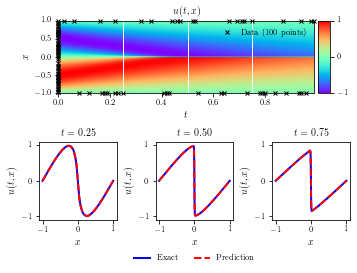

In [ ]:
import sys
import json
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

# HYPER PARAMETERS

hp = {}
# Data size on the solution u
hp["N_u"] = 100
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
hp["layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 120
hp["tf_lr"] = 0.03
hp["tf_b1"] = 0.9
hp["tf_eps"] = None
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 1000
hp["nt_lr"] = 0.6
hp["nt_ncorr"] = 50
hp["log_frequency"] = 10

# %% DEFINING THE MODEL


class BurgersInformedNN(NeuralNetwork):
    def __init__(self, hp, logger, X_f, ub, lb, nu):
        super().__init__(hp, logger, ub, lb)

        self.nu = nu

        # Separating the collocation coordinates
        self.x_f = self.tensor(X_f[:, 0:1])
        self.t_f = self.tensor(X_f[:, 1:2])

    # Defining custom loss
    def loss(self, u, u_pred):
        f_pred = self.f_model()
        return tf.reduce_mean(tf.square(u - u_pred)) + \
            tf.reduce_mean(tf.square(f_pred))

    # The actual PINN
    def f_model(self):
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(self.x_f)
            tape.watch(self.t_f)
            # Packing together the inputs
            X_f = tf.stack([self.x_f[:, 0], self.t_f[:, 0]], axis=1)

            # Getting the prediction
            u = self.model(X_f)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, self.x_f)

        # Getting the other derivatives
        u_xx = tape.gradient(u_x, self.x_f)
        u_t = tape.gradient(u, self.t_f)

        # Letting the tape go
        del tape

        nu = self.get_params(numpy=True)

        # Buidling the PINNs
        return u_t + u*u_x - nu*u_xx

    def get_params(self, numpy=False):
        return self.nu

    def predict(self, X_star):
        u_star = self.model(X_star)
        f_star = self.f_model()
        return u_star.numpy(), f_star.numpy()

# %% TRAINING THE MODEL


# Getting the data
path = os.path.join("/content/drive/MyDrive/PINNs-TF2.0/1d-burgers/data", "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, \
    X_u_train, u_train, X_f, ub, lb = prep_data(
        path, hp["N_u"], hp["N_f"], noise=0.0)

# Creating the model
logger = Logger(hp)
pinn = BurgersInformedNN(hp, logger, X_f, ub, lb, nu=0.01/np.pi)

# Defining the error function for the logger and training
def error():
    u_pred, _ = pinn.predict(X_star)
    return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)


logger.set_error_fn(error)
pinn.fit(X_u_train, u_train)

# Getting the model predictions
u_pred, _ = pinn.predict(X_star)


# %% PLOTTING
plot_inf_cont_results(X_star, u_pred.flatten(), X_u_train, u_train,
                      Exact_u, X, T, x, t)
